# Numerical Solutions to Beam Problems using 3D Frame Elements

This notebook outlines the proper use of 3D frame elements for solving structural problems.  For analysis, a python class `frame3D` has been used to contain all the information containing the beam.  Functions have been written within the `frame3D` class for the solution, processing, and interogation of the beam problem.

In [1]:
# Initialize the Python and Jupyter Notebook environment:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

The `frame3D` class is stored in the file pyFrame3D.py. We load the file to import the class structure and associated functions into our Python environment.

In [2]:
from pyFrame3D import frame3D

a frame3D class is initiated as follows:

~~~~
beam = frame3D(npos,A,Iyy,Izz,J,E,G,kDef,P)
~~~~

Where the inputs are:

1. `npos` - an array the position of each node on the beam.  Each row is a node with each column representing it's location in the Global Coordinate system $X$, $Y$, $Z$.
3. `A` - a vector with the cross-sectional areas of each beam element. Used for solving axial loading.
4. `Iyy` - a vector containing the 2nd Area Moment of the cross-section of each beam element about the y-axis
5. `Izz` - a vector containing the 2nd Area Moment of the cross-section of each beam element about the z-axis
6. `J` - a vector containing the torsional constant (polar moment of inertia) of the cross section of each beam element about the x-axis.
7. `E` - a vector containing the Young's Modulus of each beam element.
8. `G` - a vector containing the Shear modulus of each beam element.
9. `kDef` - an array containing all known deflections for each degree of freedom.  Each row contains the degrees of freedom for each node in the order: $\delta_x$, $\delta_y$, $\delta_z$, $\theta_x$, $\theta_y$, $\theta_z$.  Unknown values are marked `np.nan`.
10. `P` - an array containing the force or moment applied for each degree of freedom.  Each row contains the forces and moments that can be applied to a given node in the order: $F_x$, $F_y$, $F_z$,  $M_x$, $M_y$, $M_z$.

In [ ]:
![The nature o](images/elementCoordinateSystem.png)

The following functions are included in the class:

* `solve()` - solves the system of equations for the beam.
* `shapeFunc(npt)` - post processes the beam solution, applying shape functions.
* `checkSingularity()` - determines whether the problem is fully constrained.
* `addPointLoad(W, Loc)` - applies a point load, `W` to the beam at position `Loc`.
* `addDstrLoad(w)` - applies a constant distributed load to the structure.
* `nodeConstrain(node)` - fixes all degrees of freedom at the specified node.
* `nodeConstrainDef(node, dx, dy, dz, thx, thy, thz)` - fixes all degrees of freedom at the specified node with values provided by the user.
* `changeLoad(Pnew)` - replaces the existing load distribution with a new one.
* `nodeload(node)` - returns the load applied at a given node.
* `constrNodes()` - returns a list of all constrained nodes.
* `maxDef()` - returns the maximum deflection and its location along the structure.
* `maxBendMom()` - returns the the largest magnitude internal bending moment.

These can be applied as functions:

~~~~
solve(beam)
shapeFunc(beam,npt)
~~~~

or as arguments

~~~~
beam.solve()
beam.shapeFunc(npt)
~~~~

## Example Problem

The beam is fixed at one end and simply supported at the other.  The beam is made of structural steel, is 20m long, 0.2m, has a circular cross-section with a 0.2m radius.

The beam will have a point load applied at distance `a` from the simply supported end and an even load distributed across it's length.

In [3]:
Length = 20 # beam length
Radx = 0.2 # radius of the beam cross-section
YM = 205e9 # beam young modulus
SM = 80e9 # beam shear modulus
W = 10000. # point load magnitude
W_dst = 2000. # distributed laod per unit length
b = 0.375*Length # location on the beam point load is applied (distance from simply supported end)
a = Length - b # Location of the beam of the point load (distance from the cantilevered end)
Ax = np.pi*Radx**2 # cross-sectional area of the beam
MoI = 0.25*np.pi*Radx**4 # 2nd area moment of the beam (about the y and z-axis)
Jx = 0.5*np.pi*Radx**4 # 2nd area moment of the beam about the x-axis

We will consider four different solutions this problem:

1. a single beam-element solution
2. a two beam-element solution
3. a twenty one beam-element solution

## A Single Element Solution

This is the simplest, least computationally intense of the numerical solutions: one beam-element with a node at each end.  The point load is applied between the nodes, and it must be decomposed into forces and moments applied at the two nodes.

The geometric and structural data is loaded below.

In [4]:
npos = np.array([[0, 0, 0],
                 [Length, 0, 0]])

A = np.array([Ax])
Iyy = np.array([MoI])
Izz = np.array([MoI])
J = np.array([Jx])
E = np.array([YM])
G = np.array([SM])

kDef = np.array([[0, 0, 0, 0, 0, 0],
                 [0, 0, 0, np.nan, np.nan, np.nan]])

P = np.zeros([2,6])

Initialize the beam by creating an instance of the frame class:

In [5]:
beam1element = frame3D(npos,A,Iyy,Izz,J,E,G,kDef,P)

Note that we have entered an empty `P` array.  While we can provide a non-zero `P` array, we can also initalize the problem with an empty array and then add additional loads using the `addPointLoad()` and `addDstrLoad()` functions.

In [6]:
beam1element.addPointLoad(np.array([0, W, 0]),a)

Now we solve the system of equations and generate the shape functions.

In [7]:
beam1element.solve()
beam1element.shapeFunc(51)

## A Two Element Solution

Set up the important information. This is much the same as before, only with a second node in the center of the beam.

In [8]:
npos = np.array([[0, 0, 0],
                 [Length/2, 0, 0],
                 [Length, 0, 0]])

A = np.array([Ax, Ax])
Iyy = np.array([MoI, MoI])
Izz = np.array([MoI, MoI])
J = np.array([Jx, Jx])
E = np.array([YM, YM])
G = np.array([SM, SM])

kDef = np.array([[0, 0, 0, 0, 0, 0],
                 [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
                 [0, 0, 0, np.nan, np.nan, np.nan]])

P = np.zeros([3,6])

Now let's initialize the beam element, add the point load, solve, and add shape functions..

In [9]:
# Initialize the class instance
beam2element = frame3D(npos,A,Iyy,Izz,J,E,G,kDef,P)

# add the loading to the beam2node.P array
beam2element.addPointLoad(np.array([0, W, 0]),a)

# solve and fit shape functions
beam2element.solve()
beam2element.shapeFunc(51)

## Another Two Element Solution

This time, let's place the node exactly where the point load is applied.

In [10]:
npos = np.array([[0, 0, 0],
                 [b, 0, 0],
                 [Length, 0, 0]])

A = np.array([Ax, Ax])
Iyy = np.array([MoI, MoI])
Izz = np.array([MoI, MoI])
J = np.array([Jx, Jx])
E = np.array([YM, YM])
G = np.array([SM, SM])

kDef = np.array([[0, 0, 0, 0, 0, 0],
                 [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan],
                 [0, 0, 0, np.nan, np.nan, np.nan]])

P = np.zeros([3,6])

#----------------------------

# Initialize the class instance
beam2elementV2 = frame3D(npos,A,Iyy,Izz,J,E,G,kDef,P)

# add the loading to the beam2node.P array
beam2elementV2.addPointLoad(np.array([0, W, 0]),a)

# solve and fit shape functions
beam2elementV2.solve()
beam2elementV2.shapeFunc(51)

## A Twenty-One Element Solution

Adding multiple nodes, effects the quality of the solution.

In [11]:
nodes = 21
n = nodes-1

npos = np.zeros((nodes,3))
xpos = np.linspace(0,Length,nodes)

for i in range(nodes):
    npos[i,0] =xpos[i]
    
A = Ax*np.ones(n)
Iyy = MoI*np.ones(n)
Izz = MoI*np.ones(n)
J = Jx*np.ones(n)
E = YM*np.ones(n)
G = SM*np.ones(n)

kDef = np.zeros([nodes,6])
kDef[:,:] = np.nan
kDef[0,:] = 0
kDef[-1,0:3] = 0

P = np.zeros([nodes,6])

#----------------------------

# Initialize the class instance
beam21element = frame3D(npos,A,Iyy,Izz,J,E,G,kDef,P)

# add the loading to the beam2node.P array
beam21element.addPointLoad(np.array([0, W, 0]),a)

# solve and fit shape functions
beam21element.solve()
beam21element.shapeFunc(11)

More elements improves the quality of the prediction.  Aligning nodes with point loads where possible, improves the accuracy.

Text(0, 0.5, 'Y deflection (m)')

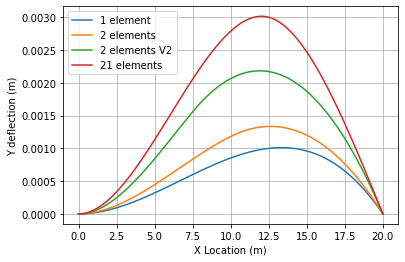

In [12]:
plt.figure()
plt.plot(beam1element.axiLoc, beam1element.defy, label='1 element')
plt.plot(beam2element.axiLoc, beam2element.defy, label='2 elements')
plt.plot(beam2elementV2.axiLoc, beam2elementV2.defy, label='2 elements V2')
plt.plot(beam21element.axiLoc, beam21element.defy, label='21 elements')
plt.legend(loc='best')
plt.grid(True)
plt.xlabel("X Location (m)")
plt.ylabel("Y deflection (m)")